In [1]:
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap

In [2]:
TOGETHER_API_KEY = "92a6ac4a8feb39c91b4a3f77219e9c452d927f5f4d543d5969cc11c210795719"
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Llama2_70B_Chat = prompter_factory(prompter_type="binary",
                                   client=client,
                                   model="meta-llama/Llama-2-70b-chat-hf")

In [6]:
prompt = "You are a model diagnosing diseases based on Doctor - Patient conversations. \
              Given a conversation, you should determine whether the patient has symptoms or not. \
              Your answer should not provide any context, it should be a simple Yes or No.\
              For instance, given the following conversation: \
              D: Are you experiencing any fatigue?\n\
              P: I have a headache every time i see a cat and i hear voices that are not there.\n\
              Your answer should be: 'Yes'.\
              Other example: given the following conversation: \
              D: Are you experiencing any fatigue?\n\
              P: I have a headache every time i see a cat and i hear voices that are not there.\n\
              Your answer should be: 'Yes'.\
              Are any medical symptoms mentioned in the transcript?"
results_llama2_70B_chat = Llama2_70B_Chat.generate(df=data, prompt=prompt)

binary task using: meta-llama/Llama-2-70b-chat-hf: 100%|██████████| 550/550 [00:14<00:00, 39.09it/s]


## Model evaluation

Llama2_70B_Chat


Bootstrapping: 100%|██████████| 1000/1000 [00:03<00:00, 258.83it/s]


accuracy: 0.693 (0.6563-0.7327 95% CI)
precision: 0.6924 (0.6551-0.7318 95% CI)
recall: 1.0 (1.0-1.0 95% CI)
f1: 0.8181 (0.7916-0.8451 95% CI)
Unstructured output ratio: 0.0 (0.0-0.0 95% CI)


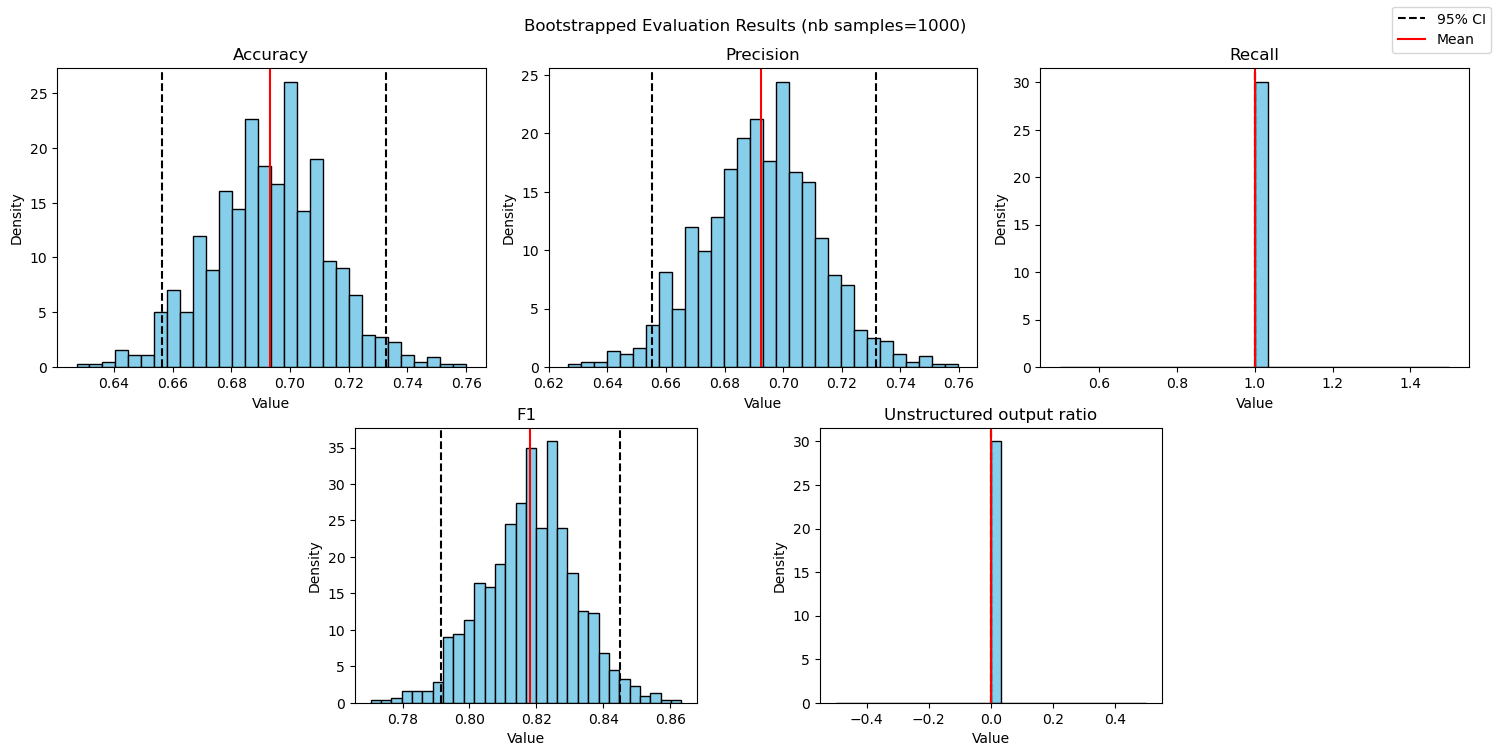

In [7]:
print("Llama2_70B_Chat")
scorer_llama2_70B_chat = scorer_factory(scorer_type="binary", data=data, results=results_llama2_70B_chat)
scorer_llama2_70B_chat.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

binary task using: mistralai/Mistral-7B-Instruct-v0.1: 100%|██████████| 550/550 [00:12<00:00, 43.53it/s] 
binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1: 100%|██████████| 550/550 [00:41<00:00, 13.32it/s]
Bootstrapping Llama2 70B Chat: 100%|██████████| 1000/1000 [00:04<00:00, 240.53it/s]


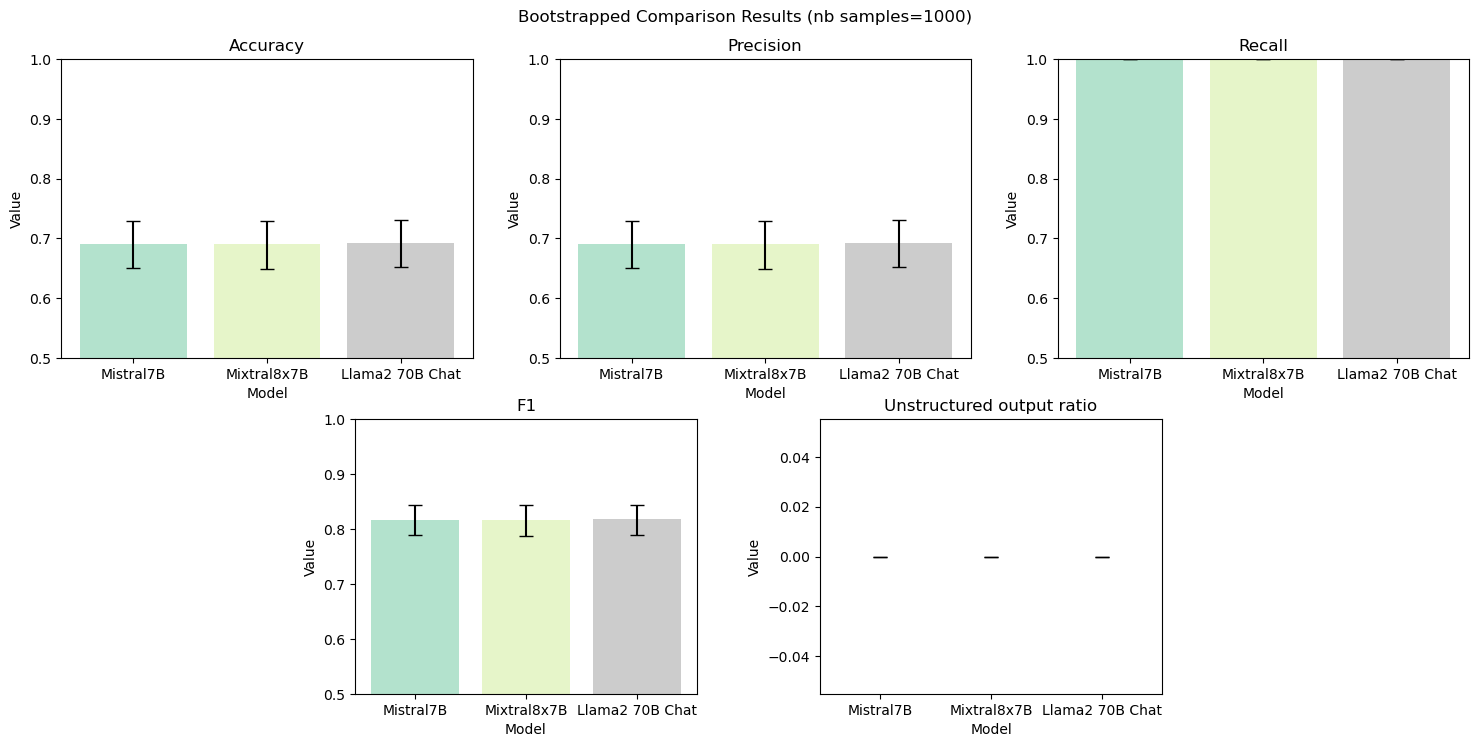

In [8]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b)

Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b)

dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b, "Llama2 70B Chat": scorer_llama2_70B_chat}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [9]:
df_llama2_70B_chat_error = scorer_llama2_70B_chat.get_error_dataframe()

In [10]:
df_llama2_70B_chat_error['Pred status'].value_counts(dropna=False)

Pred status
True    169
Name: count, dtype: int64

In [11]:
df_llama2_70B_chat_error[df_llama2_70B_chat_error["Pred status"].isnull()]["Pred output"]

Series([], Name: Pred output, dtype: object)

In [12]:
selected_columns = df_llama2_70B_chat_error.columns[:df_llama2_70B_chat_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"] + ["Pred output"]
df_llama2_70B_chat_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status,Pred output
count,169,83,4,169,169,7,169,11,11,10,169,0,169,169
unique,169,2,3,50,2,1,50,3,1,2,1,0,1,146
top,"P: Uhm, I know my grandfather had lung cancer,...",Negative,Other,MSK0033.txt,Negative,Other,MSK0033.txt,None;Other,NONE,Negative;Positive,False,NaN,True,Yes.\n\nThe patient mentions experiencing a ...
freq,1,80,2,7,162,7,7,9,11,7,169,NaN,169,7


In [13]:
with pd.option_context('display.max_colwidth', None):
    print(df_llama2_70B_chat_error["Context"].head())

7                                                                                                                                                                                                                                                                                     P: Uhm, I know my grandfather had lung cancer, but he used to smoke.\n\nD: OK, I see. How old was he? Roughly?\n\nP: Uhm, he was in his late 60s.\n\nD: OK, I'm sorry to hear that, and thank you and oh sorry, I forgot to ask her are you currently sexually active?\n\nP: No.\n\nD: OK. Have you been sexually active before?\n\nP: Uh, no. \n\nD: OK, so umm, OK. Uhm, so that was all the questions that, uhm that, that I wanted to ask, was there anything else that you wanted to umm, mention today?
10                                                                                                                                                                                                                                  

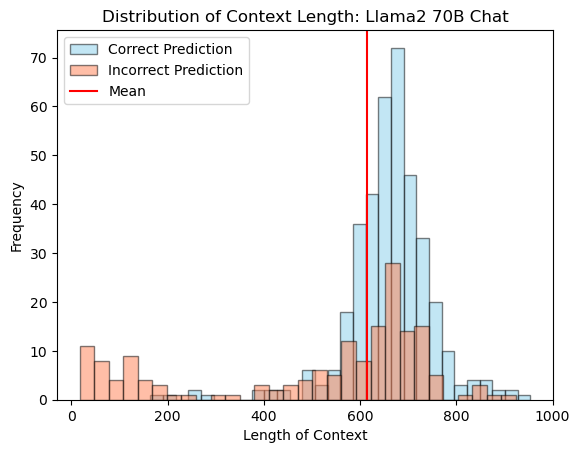

In [14]:
scorer_llama2_70B_chat.display_length_distribution("Llama2 70B Chat")